In [47]:
import os
import datetime
from dateutil.relativedelta import relativedelta
from datetime import timedelta

from xbbg import blp
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import seaborn as sns

from hurst import compute_Hc


In [48]:
def bdh_intra(tickers = None, start_date = datetime.datetime.now()-timedelta(days = 365), end_date = datetime.datetime.now(), 
              typ='TRADE', freq = 360, **kwargs) -> pd.DataFrame:

    logger = logs.get_logger(bdh_intra, **kwargs)
    while conn.bbg_session(**kwargs).tryNextEvent(): pass
    request = process.create_request(
        service='//blp/refdata',
        request='IntradayBarRequest',
        settings = [
            ('security', tickers),
            ('eventType', typ),
            ('interval', freq),
            ('startDateTime', start_date),
            ('endDateTime', end_date)
        ],
        **kwargs,
    )
    logger.debug(f'Sending request to Bloomberg ...\n{request}')
    conn.send_request(request=request, **kwargs)

    res = pd.DataFrame(process.rec_events(process.process_bar, **kwargs))
    return res
    

In [55]:
def hist_data(tickers, start_date, end_date, condition = "PX_CLOSE_1D", log = False):
    # Return a matrix of prices, with modifiable pricing condition
    data = blp.bdh(tickers, condition, start_date,end_date)
    data = data.dropna()
    if log == True:
        data = data.apply(lambda x: np.log(x))
    return data

In [56]:
end_date = datetime.datetime.today()
start_date = end_date - timedelta(days = 10000)

data = hist_data(tickers = "USDJPY CURNCY",
                start_date = start_date,
                end_date = end_date, log = True)

In [57]:
print(data)

           USDJPY CURNCY
             PX_CLOSE_1D
1995-07-03      4.438289
1995-07-04      4.439352
1995-07-05      4.440178
1995-07-06      4.441238
1995-07-07      4.442298
...                  ...
2022-11-11      4.948618
2022-11-14      4.933106
2022-11-15      4.940856
2022-11-16      4.936486
2022-11-17      4.938065

[7144 rows x 1 columns]


In [58]:
def get_hurst_exponent(time_series, max_lag=20):
    """Returns the Hurst Exponent of the time series"""
    
    lags = range(2, max_lag)

    # variances of the lagged differences
    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]

    # calculate the slope of the log plot -> the Hurst Exponent
    reg = np.polyfit(np.log(lags), np.log(tau), 1)

    return reg[0]

In [66]:
def hurst(price_series, name, lags):
    H, c, data = compute_Hc(price_series, kind = "change", simplified = True)
    f, ax = plt.subplots(figsize = (10,10))
    ax.plot(data[0], c*data[0]**H, color="deepskyblue")
    ax.scatter(data[0], data[1], color="purple")
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Time interval')
    ax.set_ylabel('R/S ratio')
    ax.grid(True)
    ax.set_title("%s Hurst and R/S Analysis\n%s - %s" %(name, price_series.index[0], price_series.index[-1]))
    plt.show()

    for lag in lags:
        hurst_exp = get_hurst_exponent(price_series.values, lag)
        print(f"Hurst exponent with {lag} lags: {hurst_exp:.4f}")

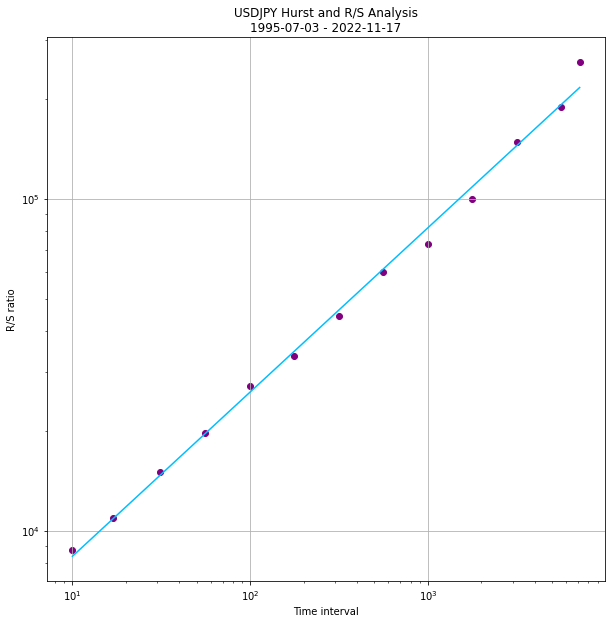

Hurst exponent with 7 lags: 0.4910
Hurst exponent with 14 lags: 0.4911
Hurst exponent with 28 lags: 0.4950
Hurst exponent with 90 lags: 0.5166
Hurst exponent with 360 lags: 0.5066


In [67]:
hurst(data, "USDJPY", lags = [7, 14, 28, 90, 360])